In [1]:
from typing import List
from logging import warning
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage import io


In [2]:
IS_NOTEBOOK: bool = True  # @param {type: "boolean"}
OPACITY_MAP_FILE_NAME: str = "opacity.png"  # @param {type: "string"}

PATH_PREFIX: str = (
    "https://raw.githubusercontent.com/YertleTurtleGit/photometric-stereo-mappings/main/test_dataset/"
    if IS_NOTEBOOK
    else "./../test_dataset/"
)

LIGHT_IMAGE_PATHS: List[str] = [
    PATH_PREFIX + str(index) + ".png" for index in range(1, 8 + 1)
]
BACK_LIGHT_IMAGE_PATHS: List[str] = [
    PATH_PREFIX + str(index) + "b.png" for index in range(1, 8 + 1)
]
OUTPUT_PATH = None if IS_NOTEBOOK else PATH_PREFIX + "output/" + OPACITY_MAP_FILE_NAME


In [3]:
def _read_image(
    image_path: str, color: bool = True, target_dtype: np.dtype = np.dtype("float64")
) -> np.ndarray:
    """Reads an image from URI and converts it to an array with specified bit depth.

    Args:
        image_path (str): The path to the image file.
        color (bool, optional): Read image as color image. Defaults to True.
        target_dtype (np.dtype, optional): The target bit depth. Defaults to np.dtype("float64").

    Returns:
        np.ndarray: The output array with shape (w,h,3) for color or (w,h) for grayscale images.
    """
    image = io.imread(image_path)
    image_dtype: np.dtype = image.dtype
    image = image.astype(target_dtype)

    if image_dtype == np.dtype("uint8"):
        image /= pow(2, 8) - 1
    elif image_dtype == np.dtype("uint16"):
        image /= pow(2, 16) - 1
    elif image_dtype == np.dtype("uint32"):
        image /= pow(2, 32) - 1

    if color:
        if len(image.shape) == 3:
            return image
        elif len(image.shape) == 2:
            return np.array([image, image, image])
        elif len(image.shape) == 4:
            return np.array([image[:, :, 0], image[:, :, 1], image[:, :, 2]])
        else:
            warning(
                "Image channel count of "
                + str(len(image.shape))
                + " with shape "
                + str(image.shape)
                + " is unknown: "
                + image_path
            )
    else:
        if len(image.shape) == 2:
            return image
        elif len(image.shape) == 3 or len(image.shape) == 4:
            return (image[:, :, 0] + image[:, :, 1] + image[:, :, 2]) / 3
        else:
            warning(
                "Image channel count of "
                + str(len(image.shape))
                + " with shape "
                + str(image.shape)
                + " is unknown: "
                + image_path
            )

    return image

In [4]:
def opacity_map(
    light_images_paths: List[str],
    back_light_images_paths: List[str],
    output_path: str = None,
    threshold: float = 6 / 16,
):

    light_images: List[np.ndarray] = [
        _read_image(light_image_path) for light_image_path in light_images_paths
    ]
    back_light_images: List[np.ndarray] = [
        _read_image(back_light_images_path)
        for back_light_images_path in back_light_images_paths
    ]

    opacity_map: np.ndarray = np.zeros(
        (light_images[0].shape[0], light_images[0].shape[1])
    )

    de_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))

    for light_image in np.concatenate((light_images, back_light_images)):
        light_image = np.clip(light_image * 255, 0, 255).astype("uint8")

        light_image = cv.blur(light_image, (3, 3))
        canny = cv.Canny(light_image, 10, 245, 3)
        canny = cv.dilate(canny, de_kernel)

        _, flood_fill, _, _ = cv.floodFill(
            canny, None, (round(light_image.shape[1] / 2), 0), 128
        )
        opacity_map[flood_fill == 128] += 255 / 16

    opacity_map[opacity_map < 255 * threshold] = 0
    opacity_map[opacity_map >= 255 * threshold] = 255
    opacity_map = 255 - opacity_map
    
    opacity_map = cv.erode(opacity_map, de_kernel)

    if output_path:
        cv.imwrite(output_path, opacity_map)
    else:
        plt.imshow(opacity_map)


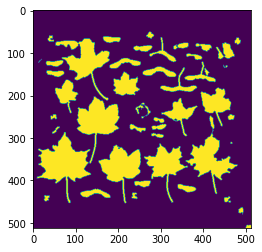

In [5]:
if __name__ == "__main__":
    opacity_map(LIGHT_IMAGE_PATHS, BACK_LIGHT_IMAGE_PATHS, OUTPUT_PATH)
